# Домашнее задание по ML-7.

# Прогнозирование биологического ответа (HW-3).



В результате выполнения данного задания необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

## Загрузка библиотек

In [1]:
# Импорт необходимых библиотек:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейной модели
from sklearn import tree #деревьев решений
from sklearn import ensemble #ансамблей
from sklearn import metrics #метрик
from sklearn.model_selection import train_test_split #сплитования выборки

# Подбор гиперпараметров:
from sklearn.model_selection import GridSearchCV #для поиска по сетке
from sklearn.model_selection import RandomizedSearchCV #для рандомизированного поиска

# Продвинутая оптимизаия:
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

%matplotlib inline
plt.style.use('seaborn')

# Заглушка для варнингов
import warnings
warnings.filterwarnings("ignore")

C:\Users\Alex\AppData\Local\Temp\ipykernel_10740\2353401913.py:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Загрузка данных

In [5]:
data = pd.read_csv('data/_train_sem09 (1).csv') 

In [6]:
# Прочитаем первые 5 строк нашего датасета
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец **Activity** содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
Остальные столбцы D1-D1776 представляют собой молекулярные **дескрипторы** — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать **F1-score**.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

# Исследование данных

In [8]:
# Информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


In [10]:
# Описание данных
data.describe()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,...,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,0.542255,0.076948,0.592436,0.068142,0.038990,0.212112,0.686653,0.274713,0.455133,0.749517,...,0.026926,0.014663,0.013863,0.021861,0.015196,0.016796,0.012263,0.011730,0.020261,0.011197
std,0.498278,0.079989,0.105860,0.078414,0.115885,0.102592,0.078702,0.090017,0.162731,0.071702,...,0.161889,0.120215,0.116938,0.146249,0.122348,0.128522,0.110074,0.107683,0.140911,0.105236
min,0.000000,0.000000,0.282128,0.000000,0.000000,0.002630,0.137873,0.006130,0.000000,0.275590,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.033300,0.517811,0.000000,0.000000,0.138118,0.625627,0.207374,0.378062,0.707339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.066700,0.585989,0.050000,0.000000,0.190926,0.674037,0.277845,0.499942,0.738961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.100000,0.668395,0.100000,0.000000,0.261726,0.740663,0.335816,0.569962,0.788177,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,0.964381,0.950000,1.000000,1.000000,0.994735,0.790831,0.989870,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


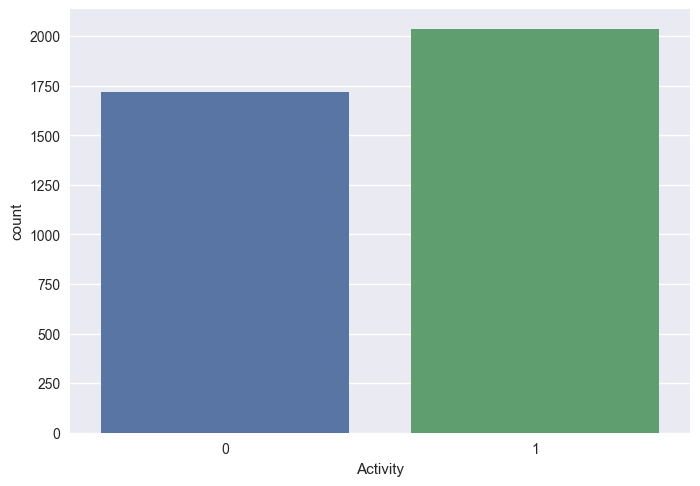

In [11]:
# Сбалансированность классов
sns.countplot(data=data, x='Activity');

Целевой класс более или менее сбалансирован

In [14]:
# Создаем матрицу наблюдений X и вектор ответов y
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение).

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

# Оптимизация гиперпараметров модели

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию.

### <center> **Логистическая регрессия**

In [17]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 50)
# Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79


### <center> **Случайный лес**

In [18]:
# Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)
# Обучаем модель
rf.fit(X_train, y_train)
# Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.81


Довольно высокие результаты метрики f1. В модели обучения методом "Случайный лес" показатель тернировочной метрики имеет признак переобучения (100% результат). Попробуем произвести подбор гиперпараметров и проверить значения метрики с оптимальными настройками.

## Базовая оптимизация:

### <center> **GridSearchCV**

In [22]:
# Модель логистической регрессии
param_grid = {'penalty': ['l2', 'none'] ,# тип регурялизации
              'solver': ['lbfgs', 'saga'], # алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, # генератор случайных чисел
        max_iter=50 # количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)

%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 875 ms
Wall time: 5.93 s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'saga'}


Значение метрики f1 снизилось на одну сотую, можно сказать, что без измененений, но это значит лишь, что мы не нашли комбинацию внешних параметров лучше, чем заданы по умолчанию. Это не удивительно и достаточно часто исходные  гиперпараметры дают неплохой результат, но это не повод останавливаться. Поэтому попробуем расширить сетку гиперпараметров.

In [25]:
# Модель логистической регрессии
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_grid=param_grid, 
    cv=5,
    n_jobs = -1
)  
%time grid_search_1.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_1.score(X_test, y_test)))
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 1.05 s
Wall time: 33.2 s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


Таким образом немного удалось улучшить значение метрик, но они равны заданным по умолчанию.

In [27]:
# Случайный лес
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5,
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 1.06 s
Wall time: 20.4 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


Хорошие показатели метрик. Но возможно стоит обратить внимание на переобучение в обучающем наборе данных.

In [28]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))

Наилучшая модель:
LogisticRegression(max_iter=50, random_state=42, solver='saga')


In [29]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.76


In [30]:
# Посмотрим на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.177799,0.045670,0.023196,0.006555,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.736667,0.765000,0.780000,0.745,0.746667,0.754667,0.015684,21
1,2.999848,0.030241,0.018348,0.001869,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.738333,0.763333,0.781667,0.745,0.745000,0.754667,0.015861,21


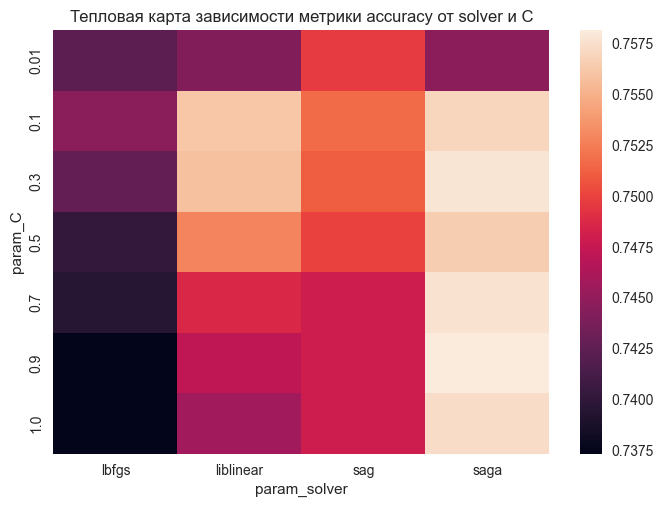

In [31]:
# Точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) # задаем размер графика

### <center> **RandomizedSearchCV**

In [34]:
# Логистическая регрессия
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 13.7 s
Wall time: 4min 55s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.23}


Значение метрик остается на уровне параметров, заданных по-умолчанию.

In [35]:
# Случайный лес
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 797 ms
Wall time: 16.5 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'n_estimators': 80, 'min_samples_leaf': 5, 'max_depth': 22}


Результаты немного выше, чем в методе GridSearchCV.

### **Вывод по базовой оптимизации:**
На множестве примеров нам удалось продемонстрировать более эффективную и быструю работу RandomizedSearchCV над GridSearchCV.

## Продвинутая оптимизация:

### <center> **Hyperopt**
### <center> **(Случайный лест)**

In [39]:
# Зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [40]:
# Зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # Функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # Построение модели Случайный лес
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # Обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # С кросс-валидацией
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # Метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [41]:
%%time
# Начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [02:03<00:00,  6.17s/trial, best loss: -0.8080577050312506]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
CPU times: total: 16.1 s
Wall time: 2min 3s


In [42]:
# Рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82


Можем продолжить поиск гиперпараметров, чтобы улучшить результаты, т.к. для байесовских оптимизаторов это возможнопотому, что они ориентируются на прошлые результаты: предыдущие входные данные для целевой функции и результирующие потери.

In [43]:
# Увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) и используем старый trials
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=23, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 23/23 [00:23<00:00,  7.78s/trial, best loss: -0.8120423125971236]
Наилучшие значения гиперпараметров {'max_depth': 20.0, 'min_samples_leaf': 2.0, 'n_estimators': 160.0}


In [44]:
# Рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.83


Результат показывает, что Hyperot смог улучшить нашу метрику в методе обучения модели "Случайный лес", но остатется высоким значение метрики в обучающем наборе данных, что может свидетельствовать о переобучении модели.

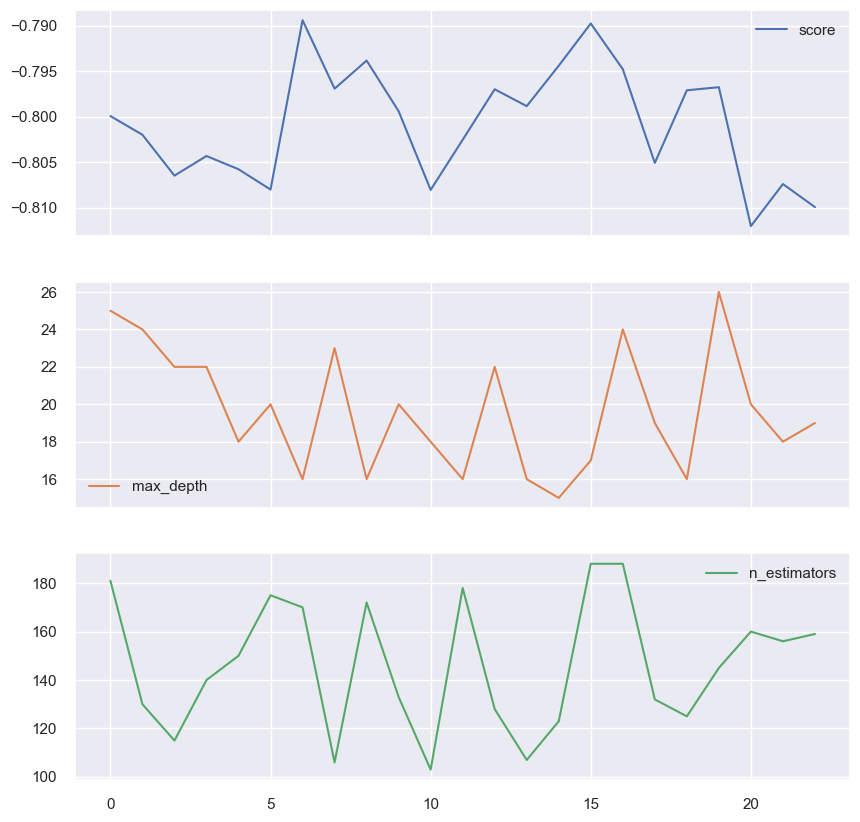

In [45]:
# Диаграммы показателей точности при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# Тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

### <center> **Hyperopt**
### <center> **(Логистическая регрессия)**

In [98]:
# Зададим пространство поиска гиперпараметров
pen = ['l1', 'l2']
sol = ['liblinear', 'saga']
space_lr={'penalty': hp.choice('penalty', ['l1', 'l2']), # тип регуляризации
       'solver': hp.choice('solver', ['liblinear', 'saga']), # алгоритм оптимизации
       'C': hp.uniform('C', low=0.01, high=1) # уровень силы регурялизации
      }

trials = Trials() # используется для логирования результатов

In [93]:
# Функция
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # Функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': str(params['penalty']), 
              'solver': str(params['solver']), 
             'C': float(params['C'])
              }
    # Используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state)
    # Обучаем модель
    model.fit(X, y)
    #score = metrics.f1_score(y,model.predict(X))
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean() # с кросс-валидацией
    # Метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [94]:
%%time

# Начинаем подбор гиперпараметров
best=fmin(hyperopt_lr, # наша функция 
          space=space_lr, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 50/50 [06:25<00:00,  7.71s/trial, best loss: -0.7843573900686336]
Наилучшие значения гиперпараметров {'C': 0.11205124547519595, 'penalty': 0, 'solver': 1}
CPU times: total: 36.7 s
Wall time: 6min 25s


In [99]:
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=pen[best['penalty']],
    solver=sol[best['solver']],
    C=float(best['C'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.81
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79


Очень хорошие показатели выбранной метрики. Удалось победить переобучение.

### <center> **Optuna**
### <center> **(Случайный лест)**

In [100]:
# Настроим оптимизацию гиперпараметров для алгоритма случайного леса
def optuna_rf(trial):
  # Задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # Создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # Обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [101]:
%%time
# Создаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

[I 2024-02-20 17:37:58,077] A new study created in memory with name: RandomForestClassifier
[I 2024-02-20 17:38:00,947] Trial 0 finished with value: 0.9514800122062863 and parameters: {'n_estimators': 149, 'max_depth': 15, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9514800122062863.
[I 2024-02-20 17:38:03,085] Trial 1 finished with value: 0.925473427000611 and parameters: {'n_estimators': 135, 'max_depth': 17, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9514800122062863.
[I 2024-02-20 17:38:05,788] Trial 2 finished with value: 0.9367552703941339 and parameters: {'n_estimators': 152, 'max_depth': 11, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9514800122062863.
[I 2024-02-20 17:38:07,443] Trial 3 finished with value: 0.9234537660747091 and parameters: {'n_estimators': 105, 'max_depth': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9514800122062863.
[I 2024-02-20 17:38:09,562] Trial 4 finished with value: 0.9767726161369193 and parameters: {'n_e

CPU times: total: 52.2 s
Wall time: 3min 6s


In [102]:
# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 194, 'max_depth': 25, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


Высокий показатель метрики на обучающем наборе. Возможно снова переобучение.

In [103]:
# Рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82


Показатель метрики на тестовом наборе данных удалось улучшить, имеет довольно высокое значение.

In [104]:
# График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [105]:
# График важности гиперпараметров
optuna.visualization.plot_param_importances(study, target_name="f1_score")

In [106]:
# График контура отношений гиперпараметров
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

### <center> **Optuna**
### <center> **(Логистическая регрессия)**

In [107]:
# Настроим оптимизацию гиперпараметров для алгоритма логистической регрессии
def optuna_lr(trial):
 # Задаем пространства поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])
    C = trial.suggest_float('C', 0.01, 1)

    # Создаем модель
    model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state)
    # Обучаем модель
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

    return score

In [108]:
%time
# Создаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study2 = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study2.optimize(optuna_lr, n_trials=50)

[I 2024-02-20 17:50:45,566] A new study created in memory with name: LogisticRegression


CPU times: total: 0 ns
Wall time: 0 ns


[I 2024-02-20 17:50:49,188] Trial 0 finished with value: 0.7475536741581407 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.4968075194877932}. Best is trial 0 with value: 0.7475536741581407.
[I 2024-02-20 17:50:57,881] Trial 1 finished with value: 0.7691686998431067 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.8101087628692303}. Best is trial 1 with value: 0.7691686998431067.
[I 2024-02-20 17:51:02,451] Trial 2 finished with value: 0.7475536741581407 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.995111461859385}. Best is trial 1 with value: 0.7691686998431067.
[I 2024-02-20 17:51:06,568] Trial 3 finished with value: 0.7776628252581069 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.36665008860139237}. Best is trial 3 with value: 0.7776628252581069.
[I 2024-02-20 17:51:08,850] Trial 4 finished with value: 0.7715590402825551 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.6977863429940951}. Best is trial 3 with value: 0.7

In [110]:
# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study2.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study2.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.13610554656960328}
f1_score на обучающем наборе: 0.78


In [112]:
# Рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study2.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79


Значение ключевой метрики немного снизилось, но зато нет показателей переобучения в обучающем наборе данных.

# **ВЫВОД:**

Лучшего результата ключевой метрики удалось добиться методом Optuna и при алгоритме обучения модели Случайным лесом. Но есть вероятность переобучения, т.к. модель могнла подстроиться под обучающий набор данных.

Показатели метрики методом Optuna при алгоритме обучения модели Логистической регрессии немного ниже, но являются вполне приемлемыми для поставленной задачи без признаков переобучения в обучающем наборе данных.

Считаем, что эксперимент проведен успешно, намеченные цели достигнуты.